In [1]:
#  Copyright 2022 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
#  IARAI licenses this file to You under the Apache License, Version 2.0
#  (the "License"); you may not use this file except in compliance with
#  the License. You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

In [2]:
import os
import sys
# Alternatevly, in order to make the module imports work properly set PYTHONPATH=$PWD before launching the notebook server from the repo root folder.
sys.path.insert(0, os.path.abspath("../"))  # noqa:E402

![t4c20logo](../t4c20logo.png)

In [3]:
import statistics
from collections import defaultdict

import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric
import tqdm
from IPython.core.display import HTML
from IPython.display import display
from torch import nn
from torch_geometric.nn import MessagePassing
from pathlib import Path
import numpy as np

import t4c22
from t4c22.metric.masked_crossentropy import get_weights_from_class_fractions
from t4c22.misc.t4c22_logging import t4c_apply_basic_logging_config
from t4c22.t4c22_config import class_fractions
from t4c22.t4c22_config import load_basedir
from t4c22.dataloading.t4c22_dataset_geometric import T4c22GeometricDataset
from t4c22.plotting.plot_congestion_classification import plot_segment_classifications_simple
from t4c22.misc.notebook_helpers import restartkernel  # noqa:F401

%matplotlib inline
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [4]:
t4c_apply_basic_logging_config(loglevel="DEBUG")
# load BASEDIR from file, change to your data root
BASEDIR = load_basedir(fn="t4c22_config.json", pkg=t4c22)
# city = "london"
city = "melbourne"
# city = "madrid"
dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("tmp/processed"), add_nearest_ctr_edge=True)
# train_dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("/tmp/processed5"), limit=1000)
dataset.get(1), len(dataset)

(Data(x=[49510, 6], edge_index=[2, 135432], y=[135432]), 6784)

In [5]:
# Writing data to cache
for data in tqdm.notebook.tqdm(torch_geometric.loader.dataloader.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=16)):
    continue

  0%|          | 0/424 [00:00<?, ?it/s]

## Torch Geometric Dataset

In [6]:
spl = int(((0.8 * len(dataset)) // 2) * 2)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [spl, len(dataset) - spl])
len(train_dataset), len(val_dataset)

(5426, 1358)

## Testing

In [8]:
city_class_fractions = class_fractions[city]
city_class_fractions

{'green': 0.7018930324884697,
 'yellow': 0.2223245729555099,
 'red': 0.0757823945560204}

In [9]:
city_class_weights = get_weights_from_class_fractions([city_class_fractions[c] for c in ["green", "yellow", "red"]])
# city_class_weights.append(0.1) # weight for no data
city_class_weights = torch.tensor(city_class_weights).float()
city_class_weights

tensor([0.4749, 1.4993, 4.3986])

## Looking into London samples

In [25]:

t4c_apply_basic_logging_config(loglevel="INFO")
city = "london"
# Monday
day = "2019-07-01"
# load BASEDIR from file, change to your data root
BASEDIR = load_basedir(fn="t4c22_config.json", pkg=t4c22)
dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("tmp/processed"), add_nearest_ctr_edge=True, day_t_filter=lambda _day, t: _day == day)
len(dataset)

92

In [47]:
@torch.no_grad()
def create_prediction(model, predictor):
    model.to(device)
    predictor.to(device)
    city_class_weights.to(device)
    loss_f = torch.nn.CrossEntropyLoss(weight=city_class_weights, ignore_index=-1, reduction="none")
    loss_f.to(device)
    dfs = []

    for idx, data in tqdm.notebook.tqdm(enumerate(dataset), total=len(dataset)):

        data.x = data.x.nan_to_num(-1)
        data = data.to(device)
        h = model(data)

        x_i = torch.index_select(h, 0, data.edge_index[0])
        x_j = torch.index_select(h, 0, data.edge_index[1])

        # logits
        y_hat = predictor(x_i, x_j)
        df = pd.DataFrame(torch.nn.functional.softmax(y_hat, dim=1).cpu().numpy(), columns=["0", "1", "2", "3"])
        df_data = dataset.torch_road_graph_mapping._torch_to_df_cc(data=y_hat, day=day, t=idx)
        df["u"] = df_data["u"].copy(deep=True)
        df["v"] = df_data["v"].copy(deep=True)
        df["day"] = df_data["day"].copy(deep=True)
        df["t"] = df_data["t"].copy(deep=True)
        # print(data.y.cpu().numpy())
        df["y"] = data.y.nan_to_num(-1).cpu().numpy()
        df["y"] += 1
        df["y_hat"] = df[["0", "1", "2", "3"]].idxmax(axis=1).astype("int64")
        dfs.append(df)

    return dfs

In [48]:
from GNN_model import CongestioNN
from GNN_model import LinkPredictor
import json

epochs = 3

device = 1
device = f"cuda:{device}" if torch.cuda.is_available() else "cpu"
device = torch.device(device)


with open("model_parameters.json", "r") as f:
    model_parameters = json.load(f)

model = CongestioNN(**model_parameters["GNN"])
model.load_state_dict(torch.load(f"GNN_model_{epochs:03d}.pt", map_location=device))

predictor = LinkPredictor(**model_parameters["Predictor"])
predictor.load_state_dict(torch.load(f"GNN_predictor_{epochs:03d}.pt", map_location=device))

<All keys matched successfully>

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

df = create_prediction(model, predictor)
df = pd.concat(df).reset_index(drop=True)

  0%|          | 0/92 [00:00<?, ?it/s]

In [50]:
plot_df = df[df["y"] != 4].reset_index(drop=True)
plot_df

,0,1,2,3,u,v,day,t,y,y_hat
0,0.448030,0.310666,0.241304,9.059924e-08,5220719432,5220719456,2019-07-01,0,0.0,0
1,0.638207,0.235598,0.126195,1.131060e-13,17788861,17788811,2019-07-01,0,0.0,0
2,0.447976,0.315960,0.236064,1.257751e-21,319942566,107393,2019-07-01,0,0.0,0
3,0.518668,0.296591,0.184741,1.870680e-24,264835732,2623963014,2019-07-01,0,0.0,0
4,0.325166,0.331461,0.343367,6.081081e-06,26787891,27091634,2019-07-01,0,0.0,2
...,...,...,...,...,...,...,...,...,...,...
16881351,0.621299,0.243203,0.135498,8.452566e-14,1669410182,1669410184,2019-07-01,91,0.0,0
16881352,0.528672,0.282460,0.188867,1.775708e-09,2928912995,310138964,2019-07-01,91,0.0,0
16881353,0.292617,0.343205,0.364178,4.523199e-18,21565338,5265953455,2019-07-01,91,0.0,2
16881354,0.316474,0.348460,0.335066,1.450567e-27,236602,5408977443,2019-07-01,91,0.0,1


<AxesSubplot:xlabel='3', ylabel='Count'>

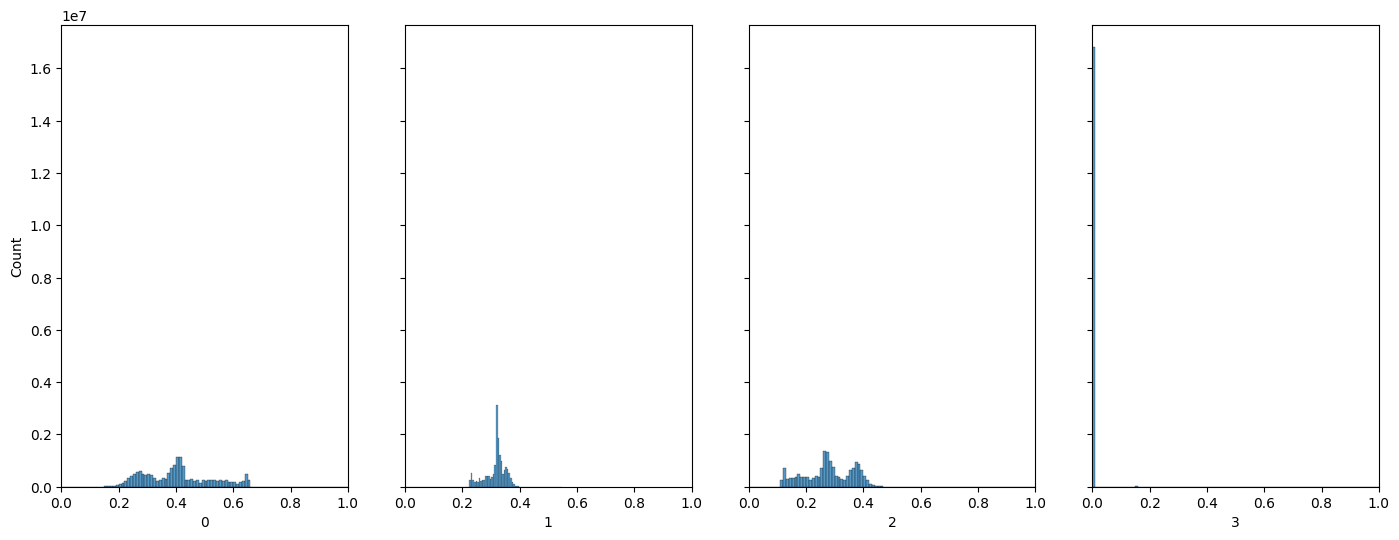

In [31]:
fig, axs = plt.subplots(ncols=4, figsize=(17, 6), sharey=True)
bins = 100
for ax in axs:
    ax.set_xlim([0.0, 1.0])
sns.histplot(data=plot_df, x="0", bins=bins, ax=axs[0])
sns.histplot(data=plot_df, x="1", bins=bins, ax=axs[1])
sns.histplot(data=plot_df, x="2", bins=bins, ax=axs[2])
sns.histplot(data=plot_df, x="3", bins=bins, ax=axs[3])

In [32]:
from sklearn.metrics import confusion_matrix

confm = confusion_matrix(plot_df["y"], plot_df["y_hat"], normalize="true")

[2022-08-18 13:22:12,041][DEBUG][68535][colorbar.py:_get_ticker_locator_formatter:897] locator: <matplotlib.ticker.AutoLocator object at 0x7f9cf31dbc40>


[Text(0.5, 23.52222222222222, 'Prediction'),
 Text(50.722222222222214, 0.5, 'True Label')]

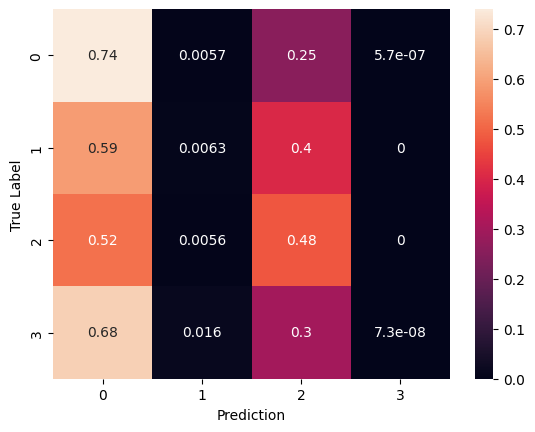

In [33]:
ax = sns.heatmap(confm, annot=True)
ax.set(xlabel='Prediction', ylabel='True Label')

In [51]:
def plot(u,v, df):
    df_ = df[(df["u"] == u) & (df["v"] == v)].copy(deep=True)
    df_["loss"] = 1.
    fig, ax = plot_segment_classifications_simple(
        df_["y_hat"].values,
        df_["y"].values,
        losses=df_["loss"].values,
        proba_green=df_["0"],
        proba_yellow=df_["1"],
        proba_red=df_["2"],
    )

[2022-08-18 13:29:56,981][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,007][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,038][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,074][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,107][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,176][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,234][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:29:57,248][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the fig

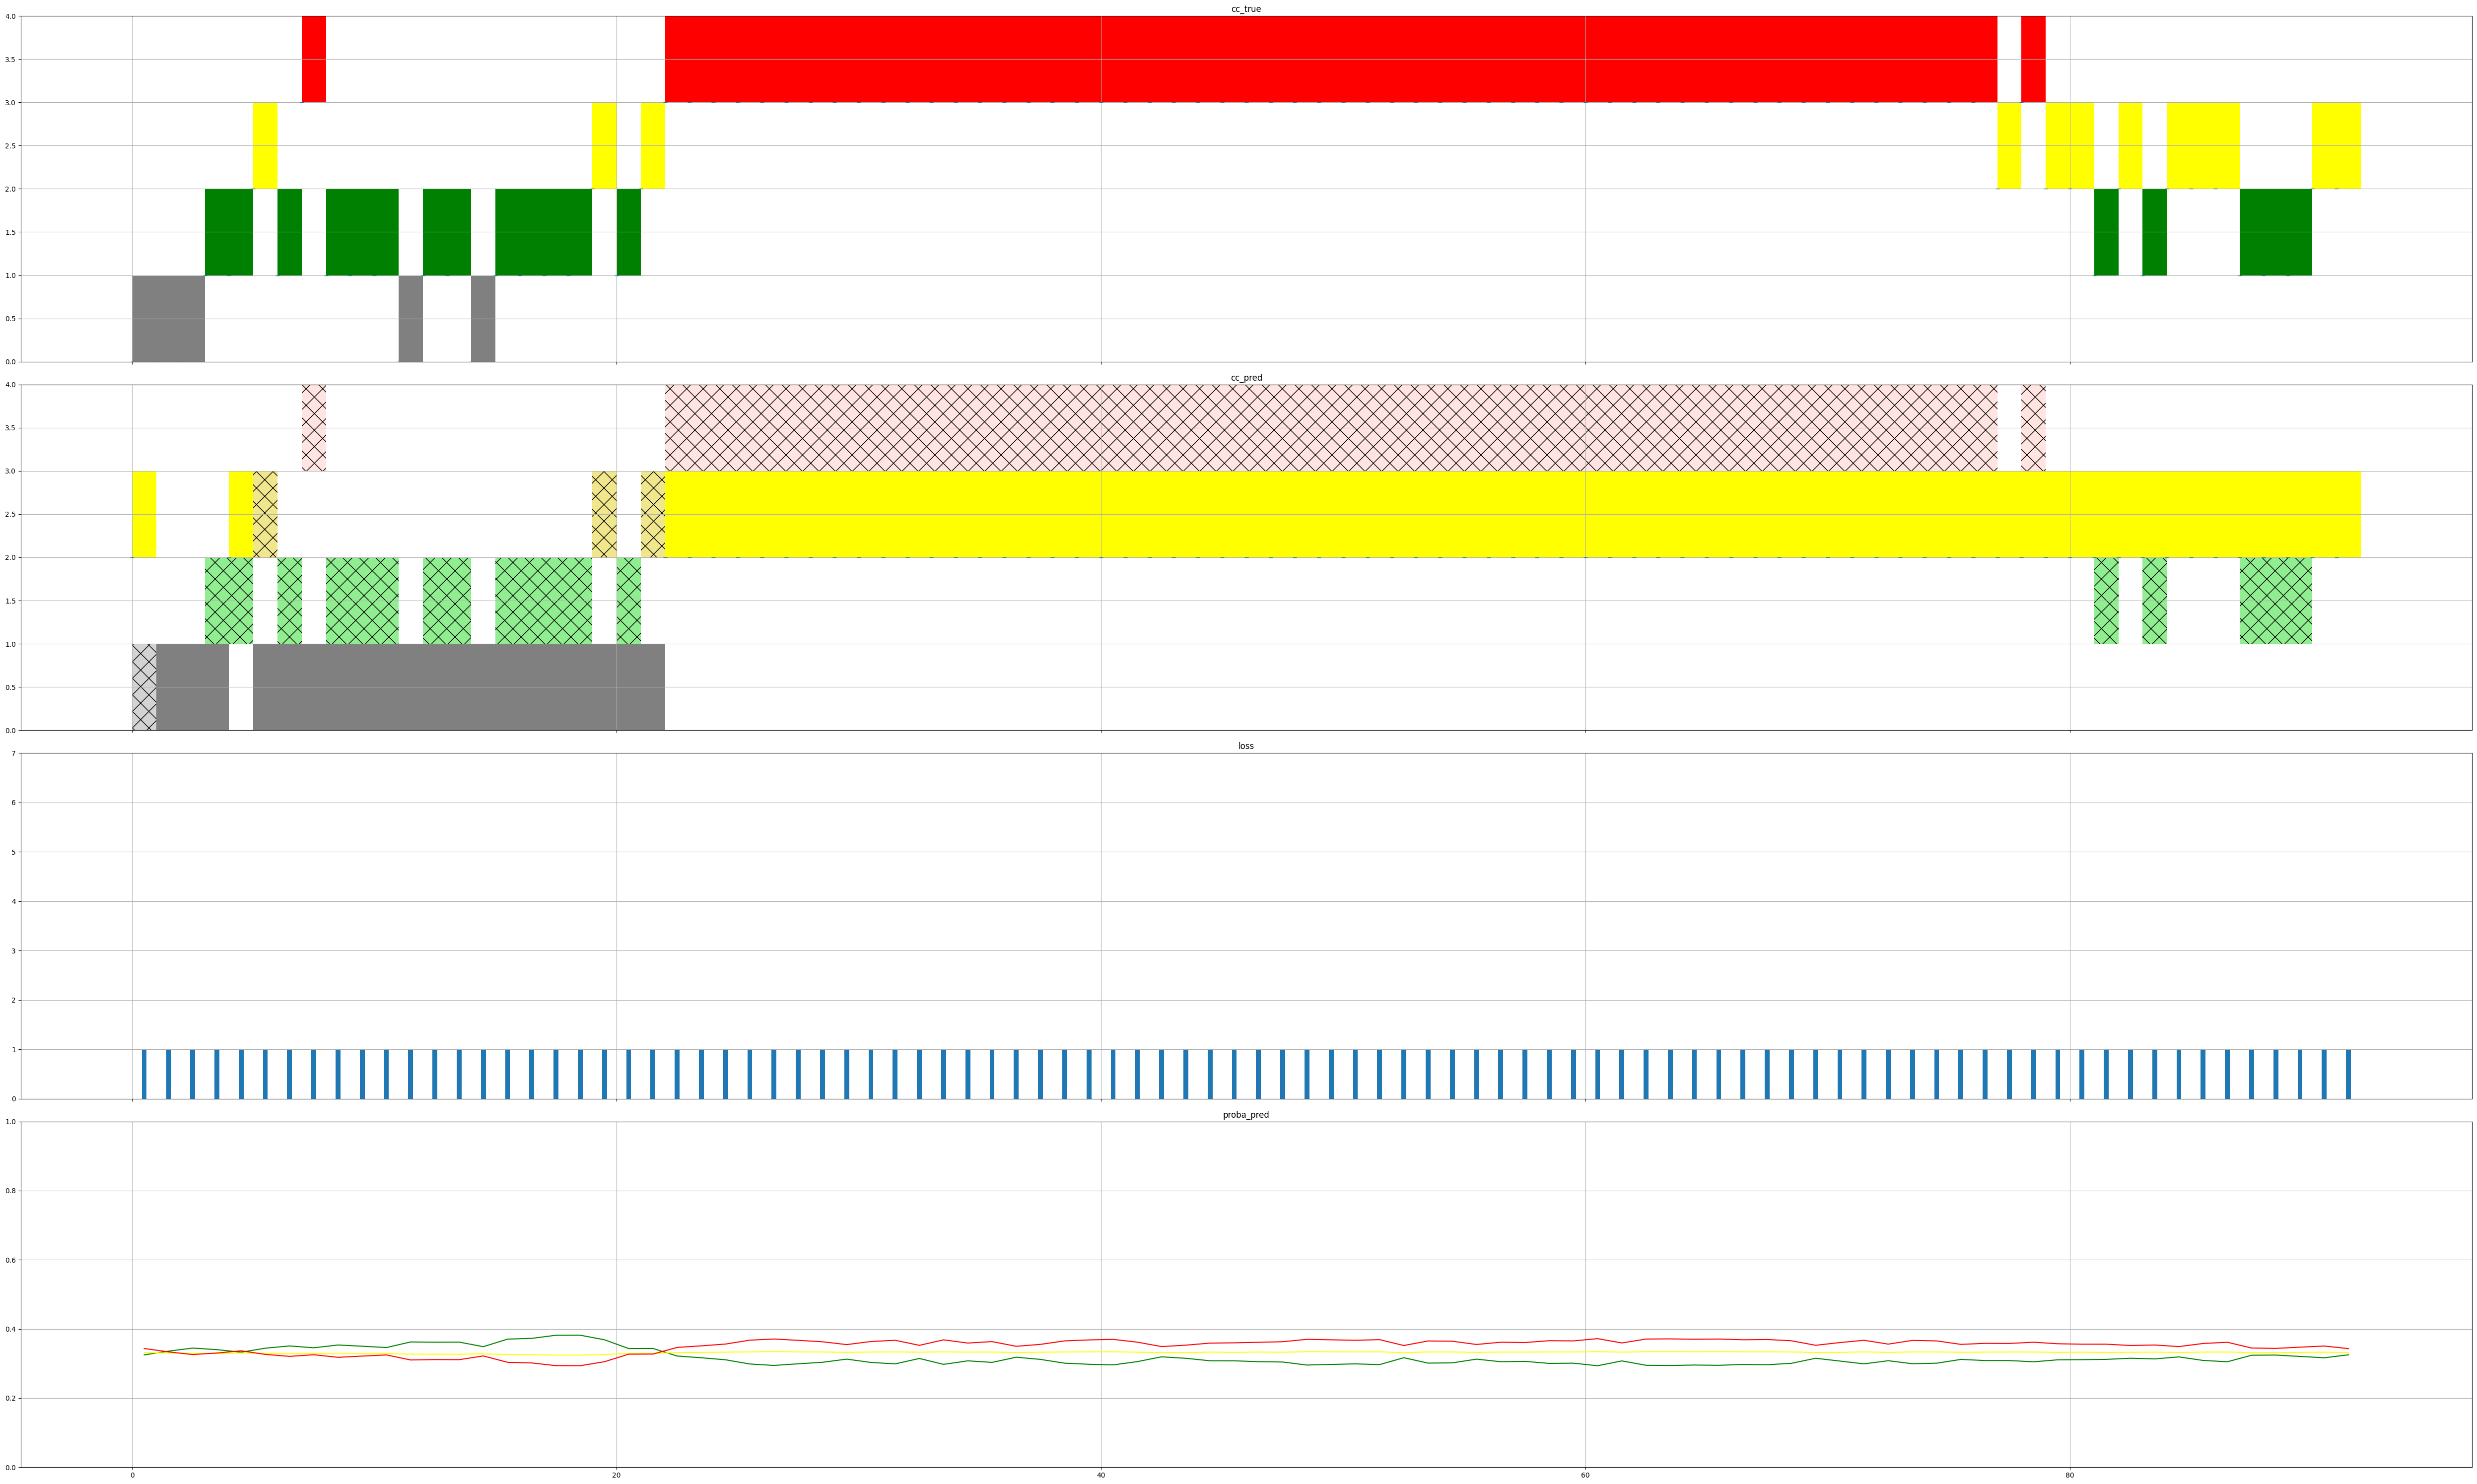

In [53]:
# Marleybone flyover, eastbound
u = 1178910690
v = 197630

plot(u, v, plot_df)

[2022-08-18 13:30:11,216][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,241][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,271][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,304][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,334][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,384][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,443][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:11,457][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the fig

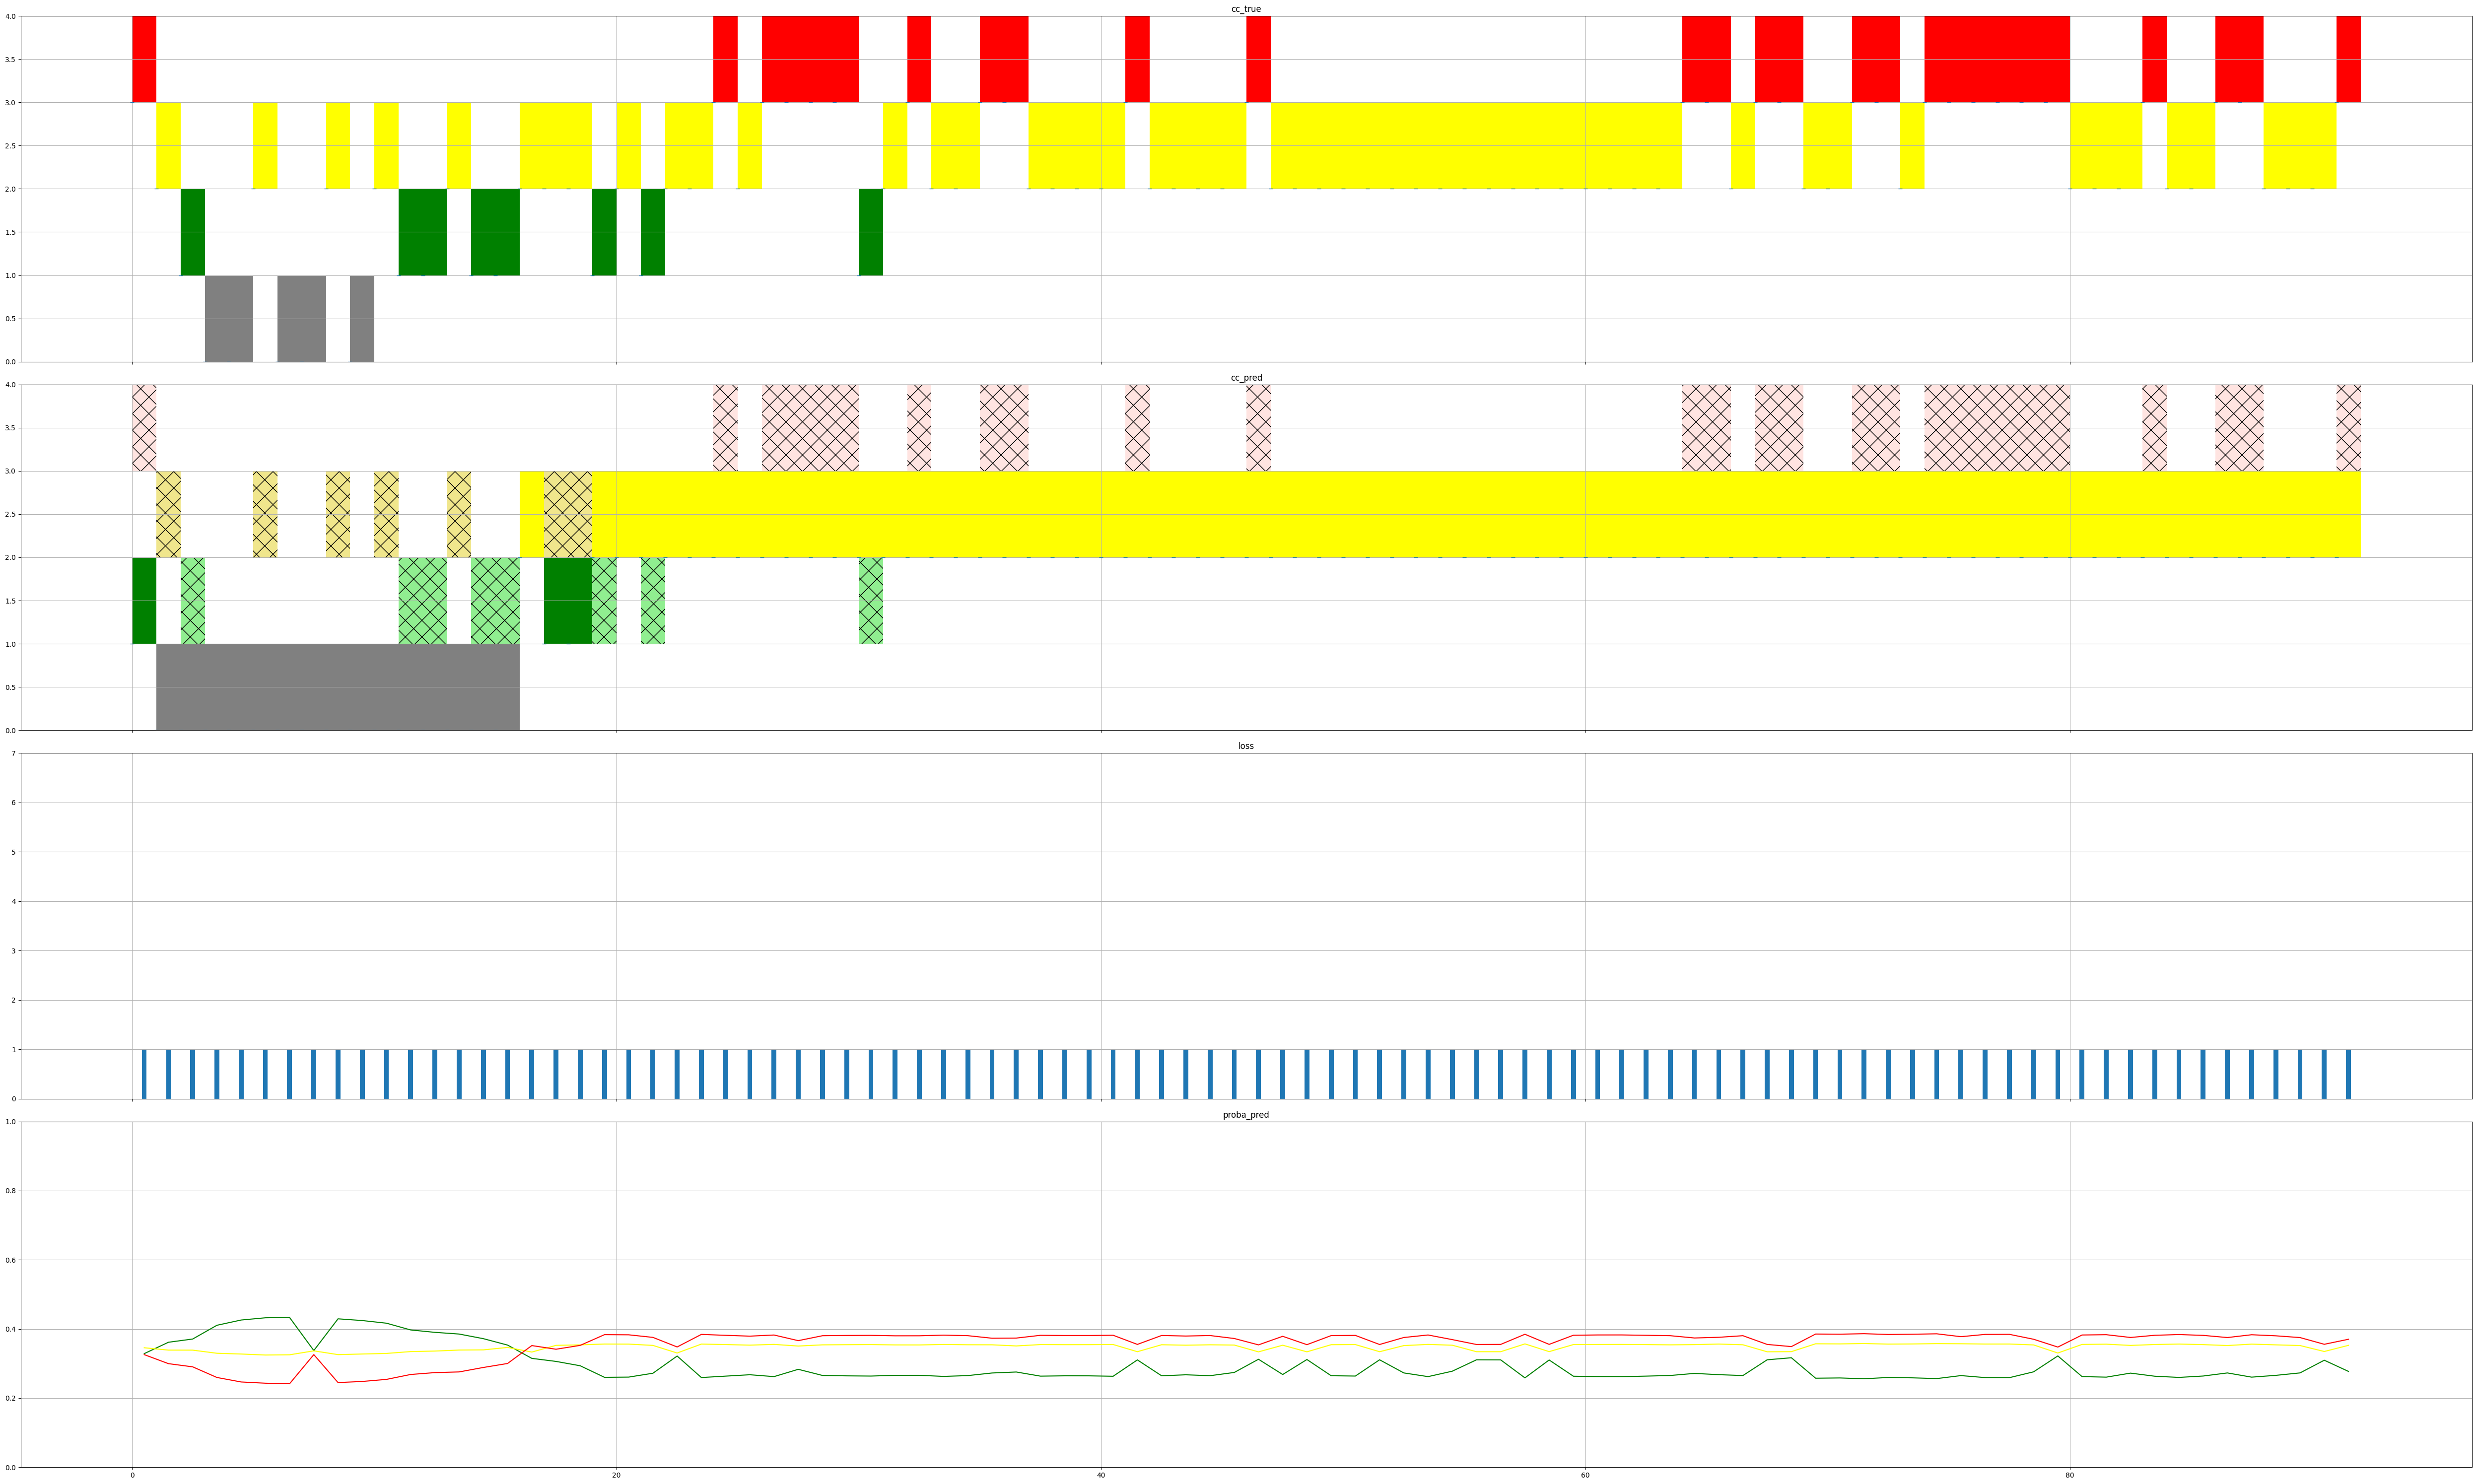

In [54]:
# Elephant and castle, northbound

u = 2180693488
v = 1868411754
plot(u, v, plot_df)

[2022-08-18 13:30:18,491][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,517][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,547][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,583][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,615][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,679][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,735][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:18,749][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the fig

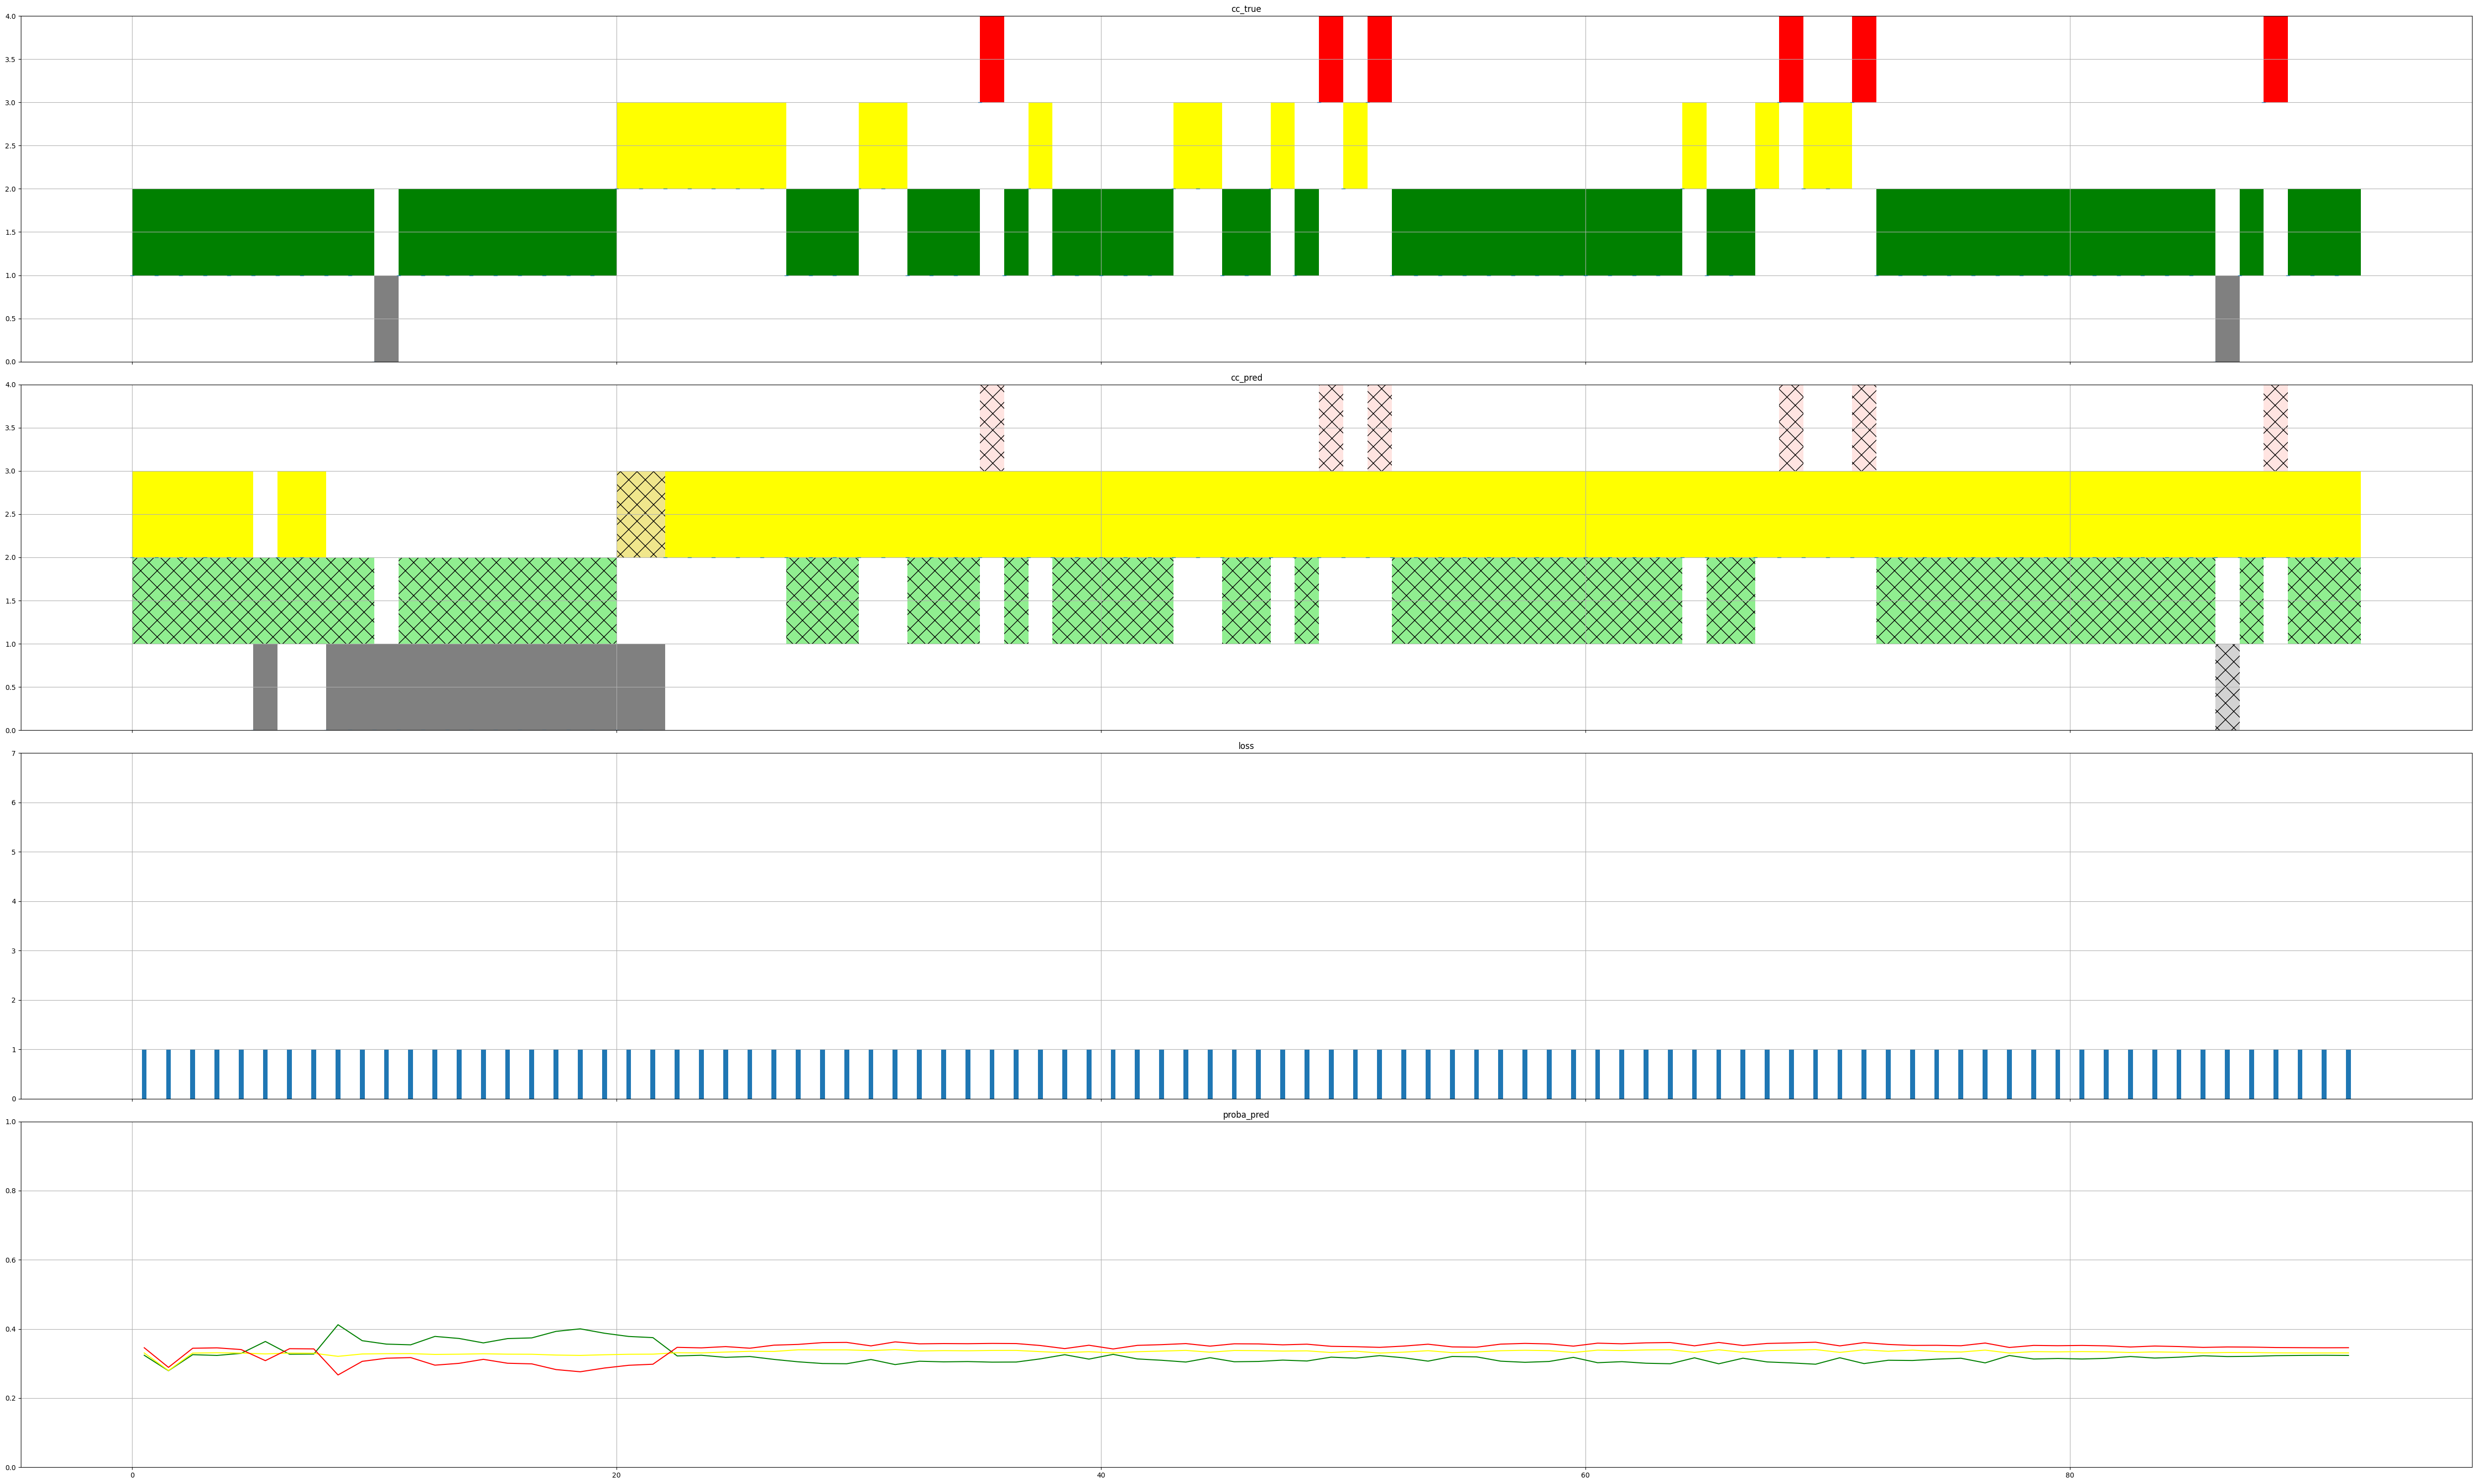

In [55]:
# M25 near Waltham, eastbound
u = 4737949241782541459
v = 5177230596161574999
plot(u, v, plot_df)

,0,1,2,3,u,v,day,t,y,y_hat


[2022-08-18 13:31:46,585][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,605][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,624][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,650][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,668][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,686][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,727][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:31:46,737][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the fig

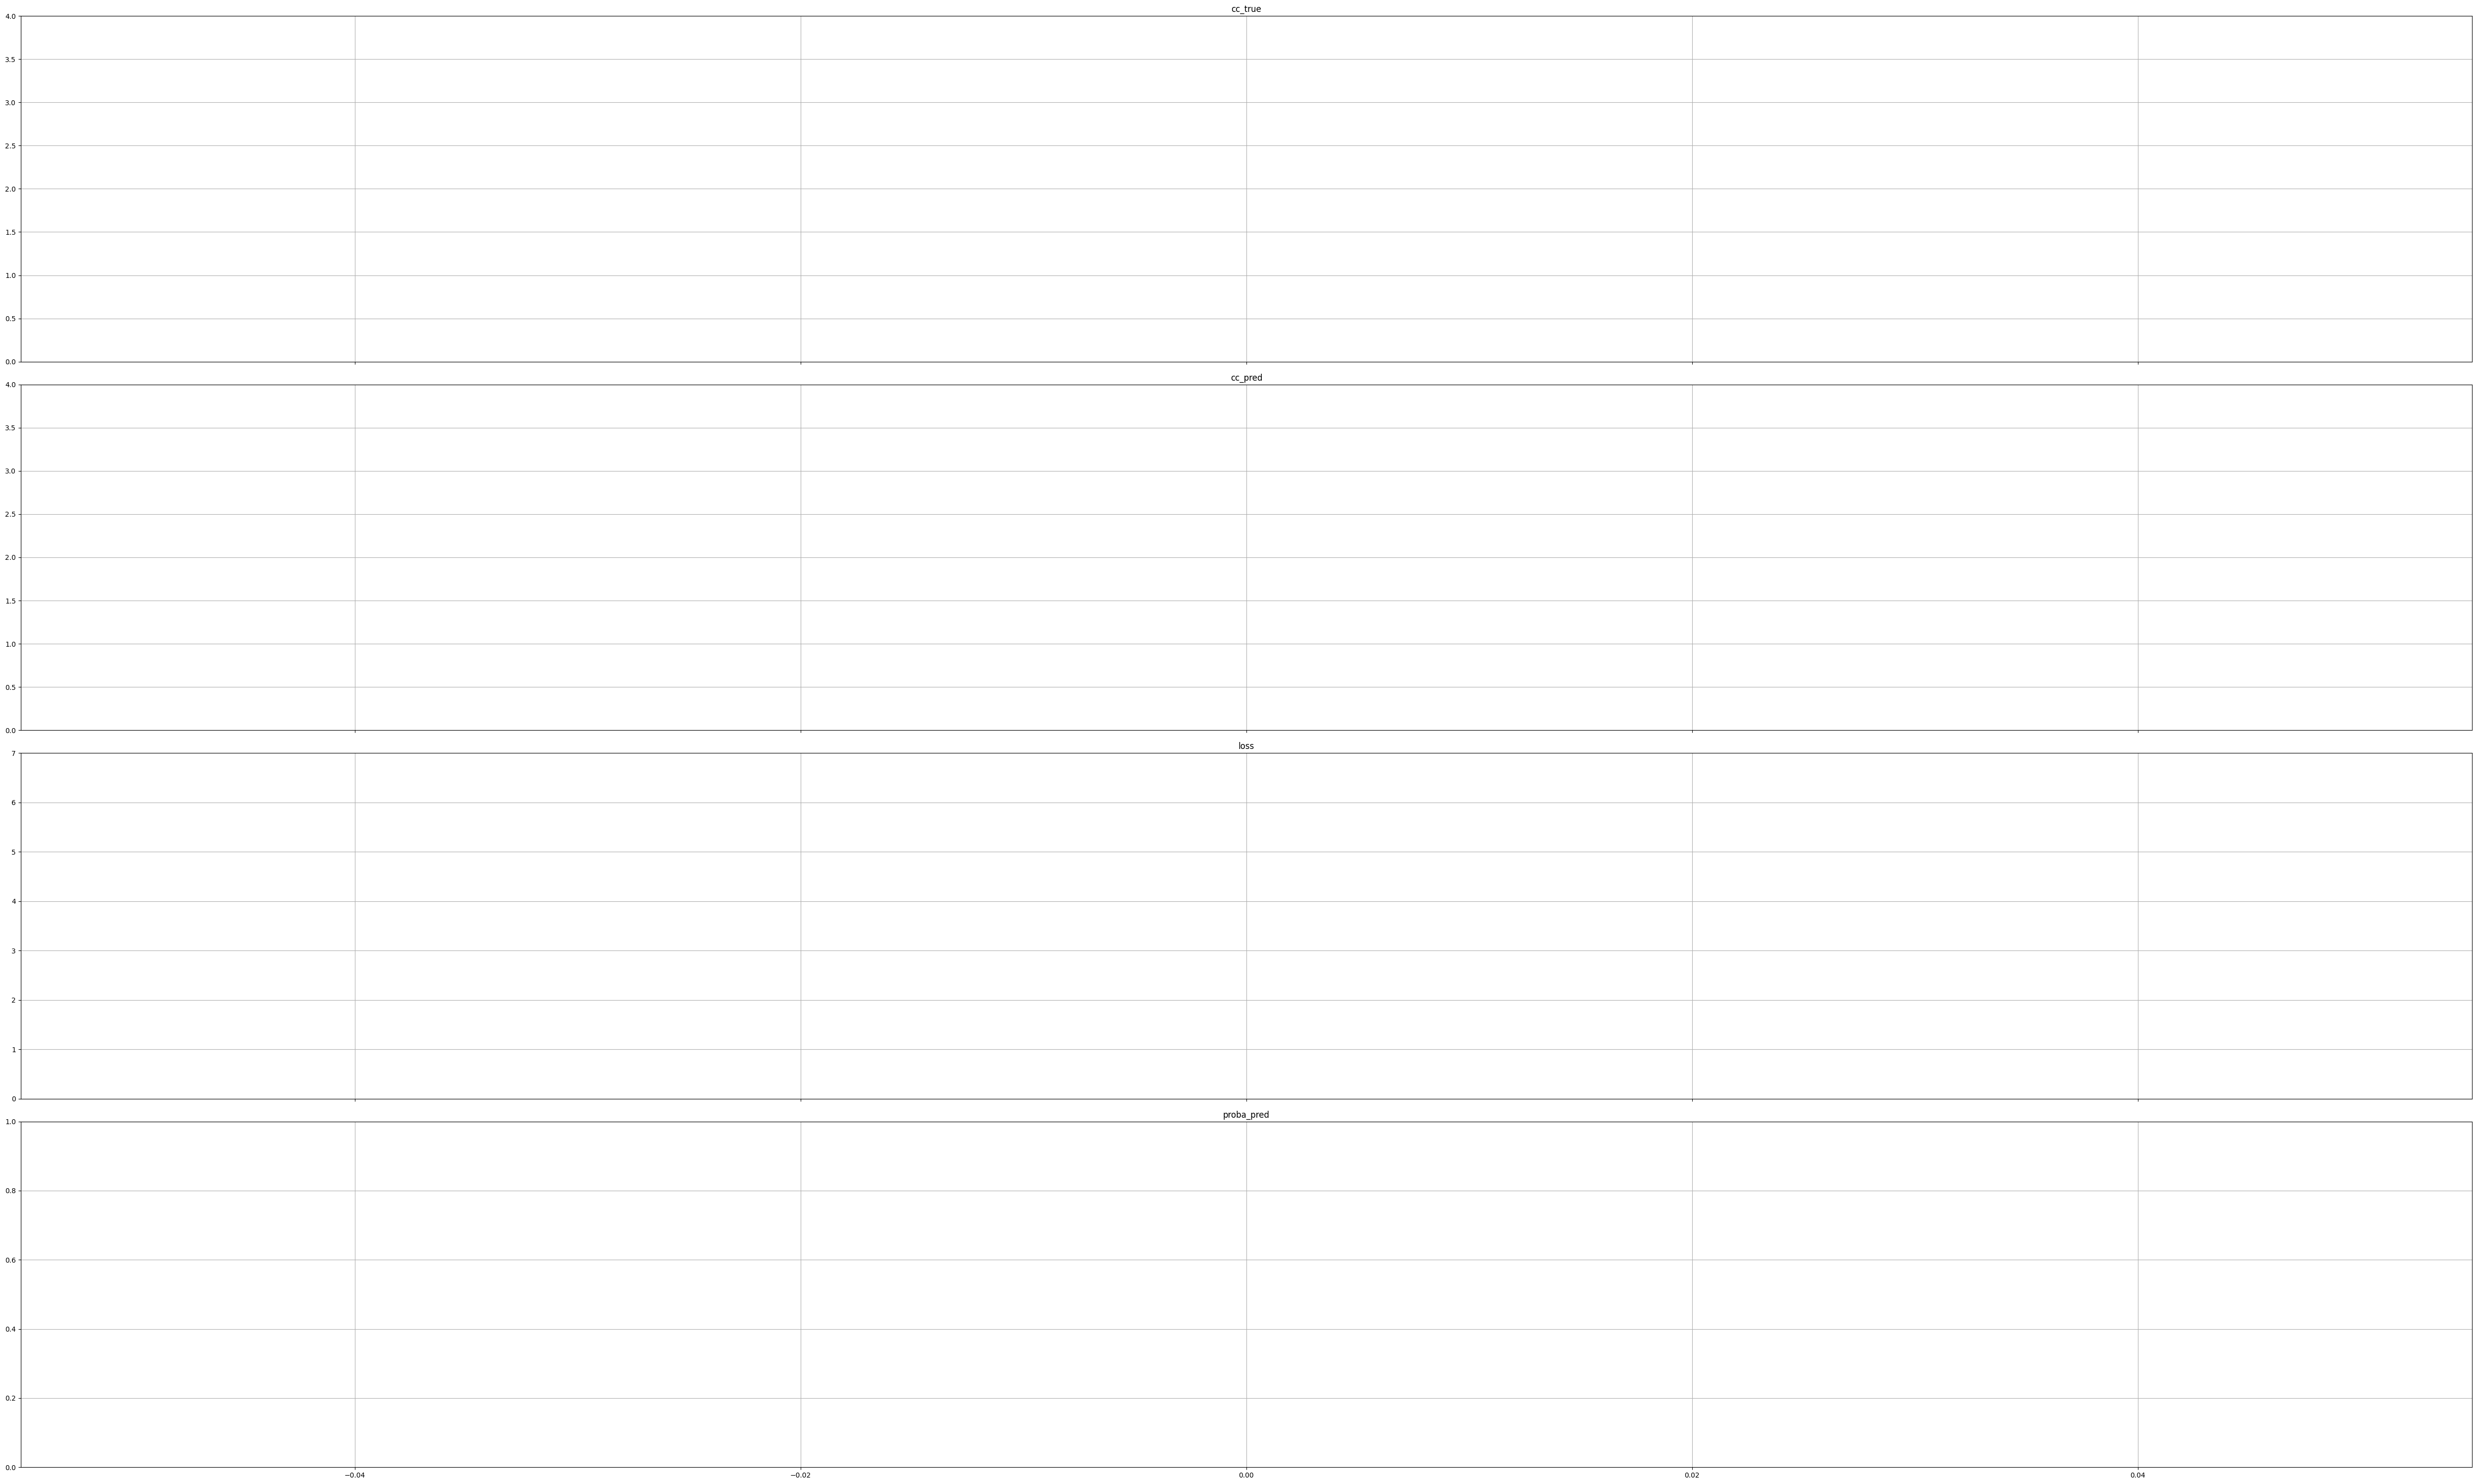

In [61]:
# M25 near Potters Bar, westbound
u = 8995114026285597218
v = 196709089314436495
plot(u, v, plot_df)
plot_df[(plot_df["u"] == u) & (plot_df["v"] == v)]

[2022-08-18 13:30:32,525][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,552][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,578][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,614][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,645][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,693][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,749][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 13:30:32,763][DEBUG][68535][_base.py:_update_title_position:3003] top of Axes not in the fig

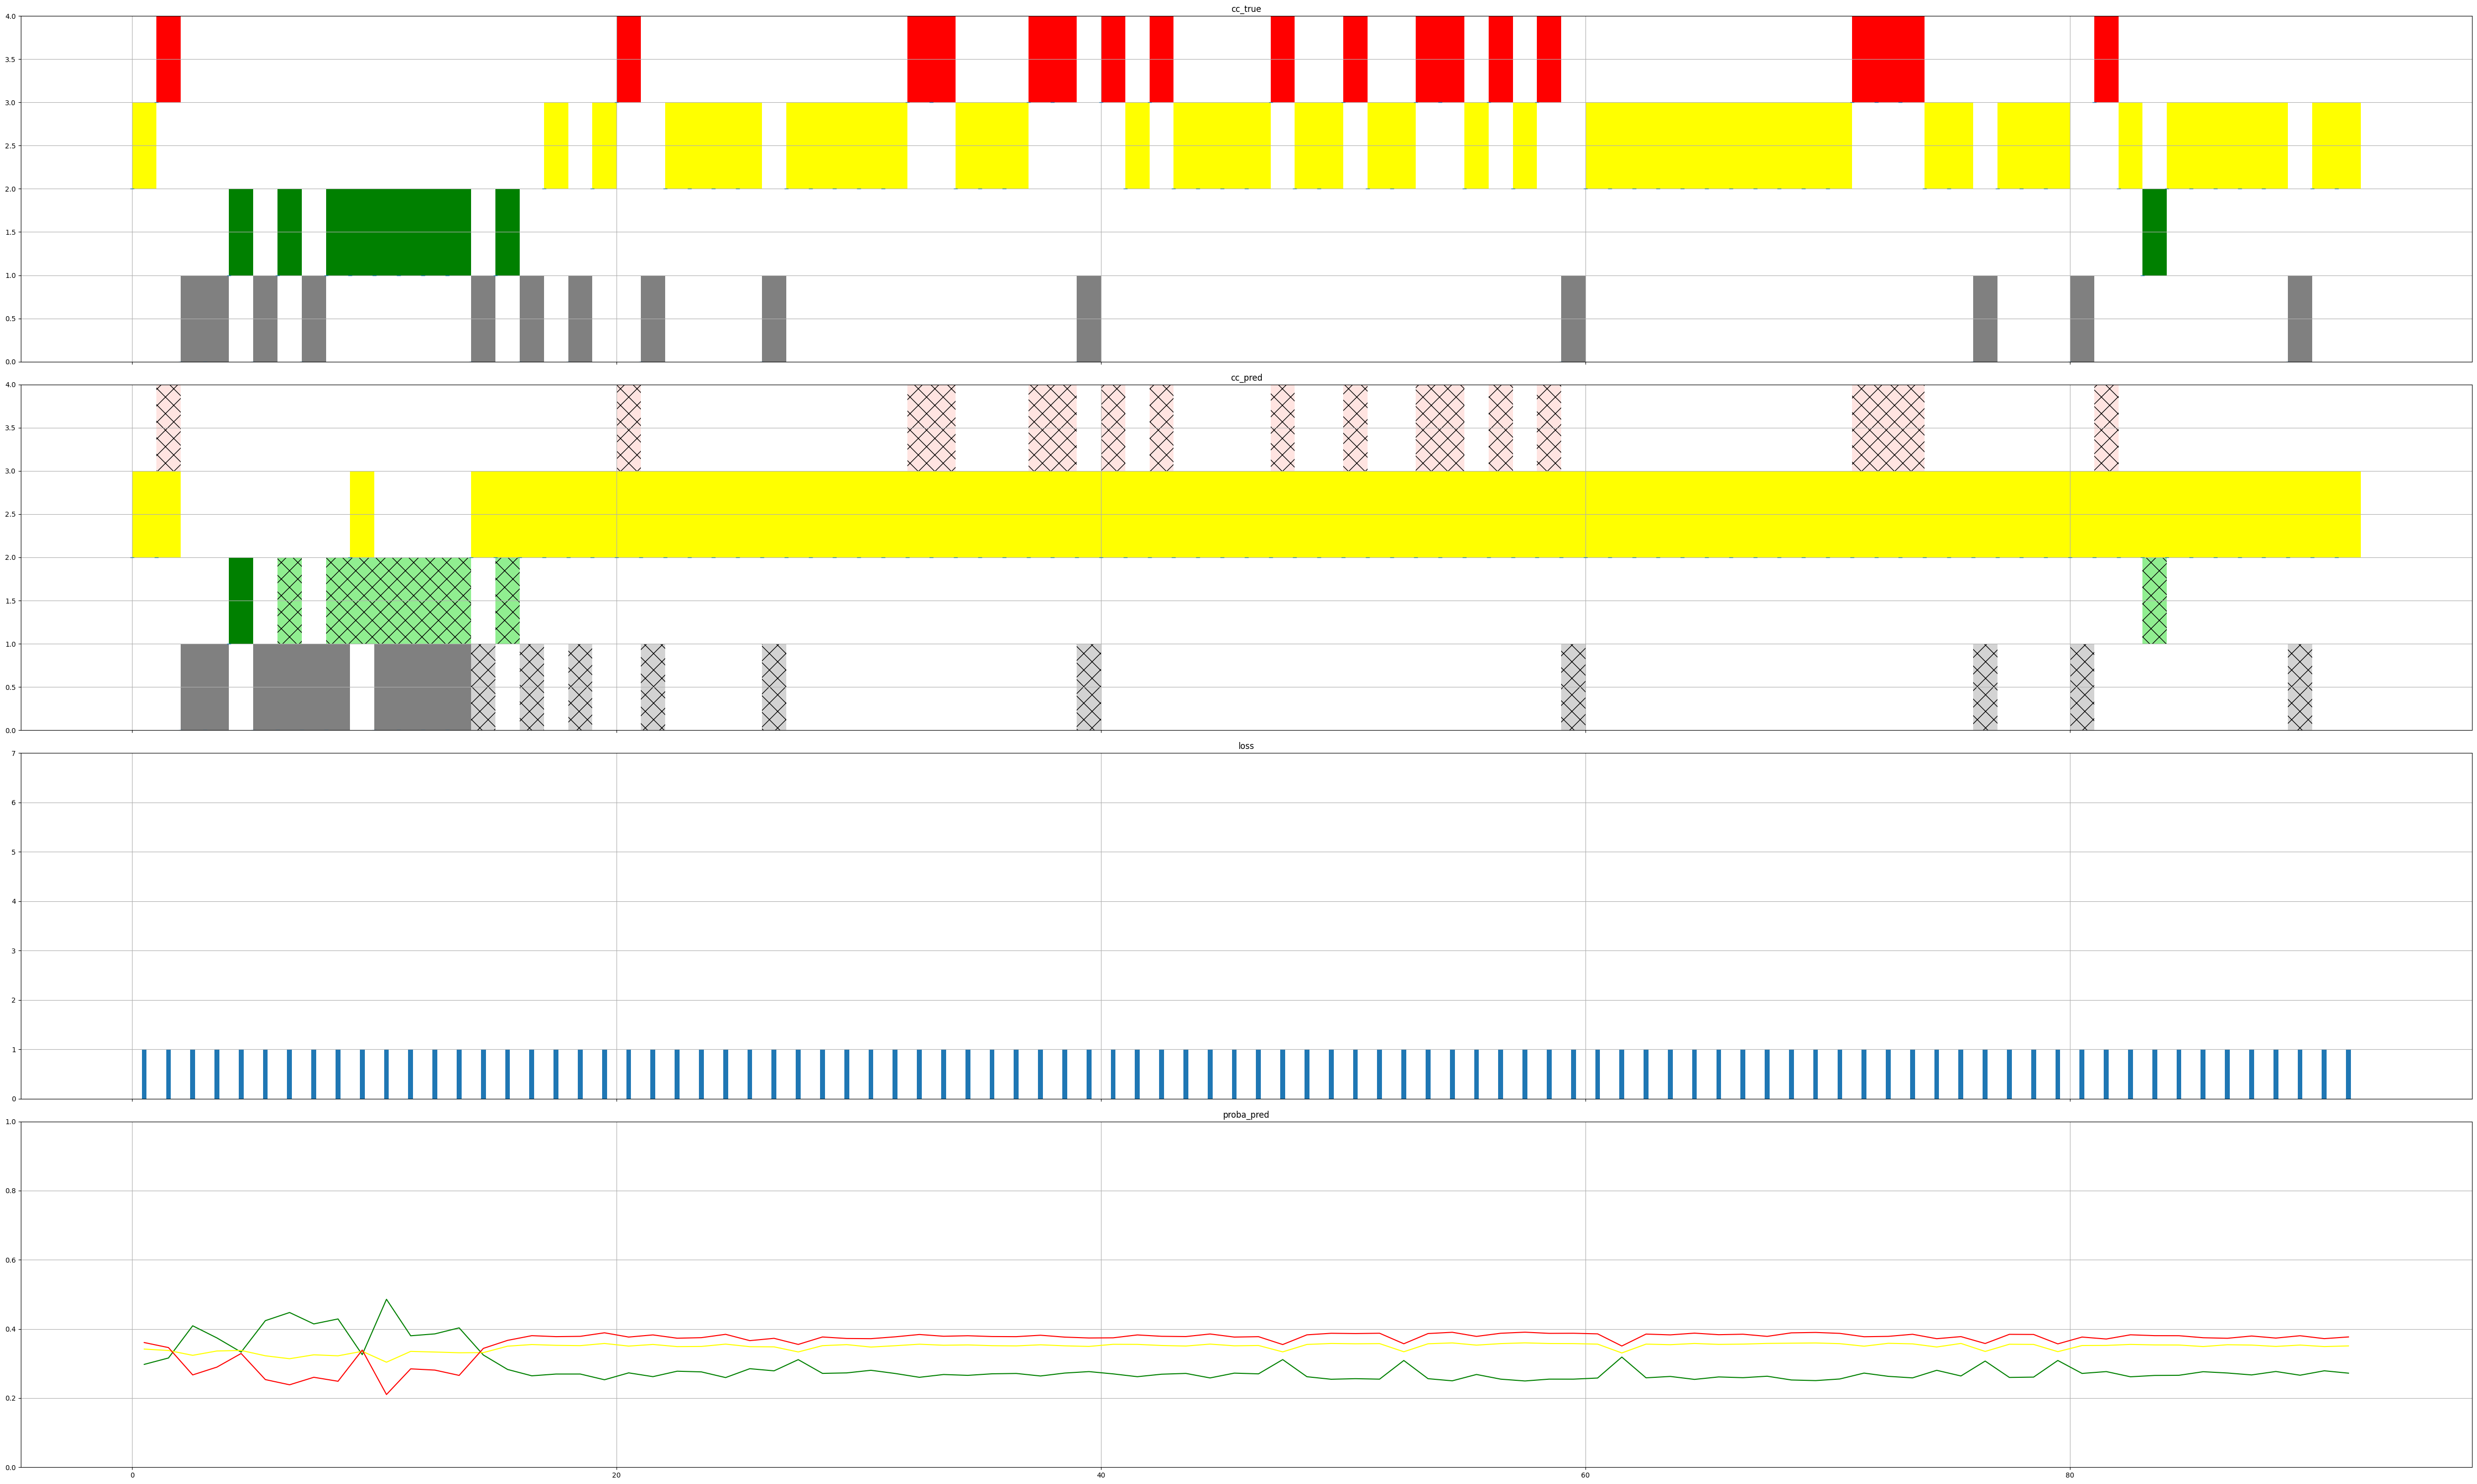

In [57]:
# at counter 08/093
u = 2180661925
v = 8953368684960847732
plot(u, v, plot_df)